# Week 3 Mini Project: CNN Cancer Detection 

By: Jaeyoung Oh

## Problem Statement

This week's mini project is about metastatic cancer identification. We will be using a dataset from a kaggle competition: https://www.kaggle.com/c/histopathologic-cancer-detection/overview. The binary class label indicates whether there is at least one pixel identifying metastatic cancer within the middle 32x32px of the images. The images themselves are 96x96px with RGB color channels. There are 220,025 train and 57,458 test images. Test image is for test and submission only, not validation. We will use a 80-20 train-validation split from the train dataset. For classification models, we will test and compare various architectures of Convolutional Neural Network.

## EDA

In [53]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np

In [82]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONWARNINGS']='ignore'
import warnings
warnings.filterwarnings("ignore") 

### Helper Functions

In [55]:
def visualize_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image Visualization")
    plt.show()

In [56]:
def visualize_images_from_directory(directory, n_images=5):
    images = os.listdir(directory)
    sample_images = np.random.choice(images, n_images, replace=False)
    
    plt.figure(figsize=(15, 10))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(directory, img_name)
        img = Image.open(img_path)
        
        plt.subplot(1, n_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        # plt.title(img_name)
    
    plt.tight_layout()
    plt.show()


In [57]:
def analyze_image_properties(image_path):
    img = Image.open(image_path)
    img_array = np.array(img)
    
    print(f"Image size: {img.size} (width x height)")
    print(f"Image mode: {img.mode}")
    print(f"Array shape: {img_array.shape}")
    
    # display image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")
    plt.show()
    
    # pixel intensity histogram
    if img_array.ndim == 2 or img_array.shape[2] == 1:
        plt.hist(img_array.ravel(), bins=50, color='gray')
        plt.title("Pixel Intensity Distribution")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.show()
    else:
        colors = ['red', 'green', 'blue']
        for i, color in enumerate(colors):
            plt.hist(img_array[:, :, i].ravel(), bins=50, color=color, alpha=0.5, label=f'{color} channel')
        plt.title("Pixel Intensity Distribution")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

### Data Description

Image size: (96, 96) (width x height)
Image mode: RGB
Array shape: (96, 96, 3)


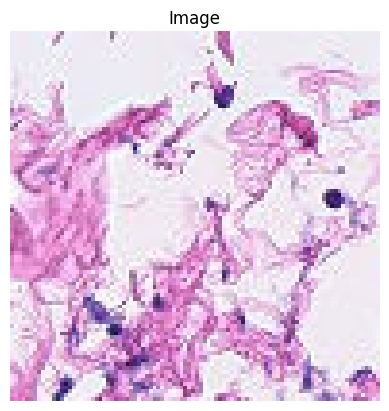

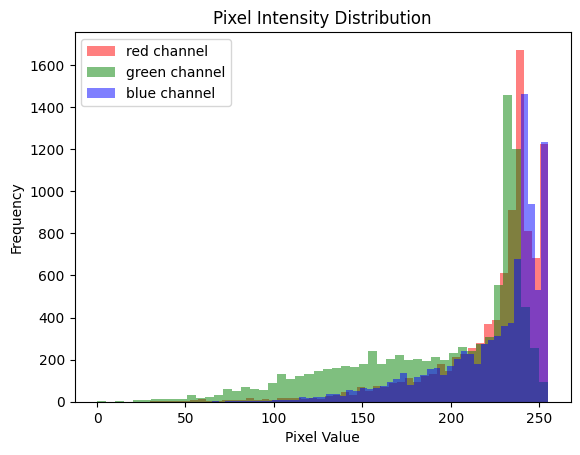

In [58]:
image_path = "./data/train/0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif"
analyze_image_properties(image_path)

We will need to address the skewness of the pixel intensities. We will simply normalize intially. Then we will try standardization if time permits.

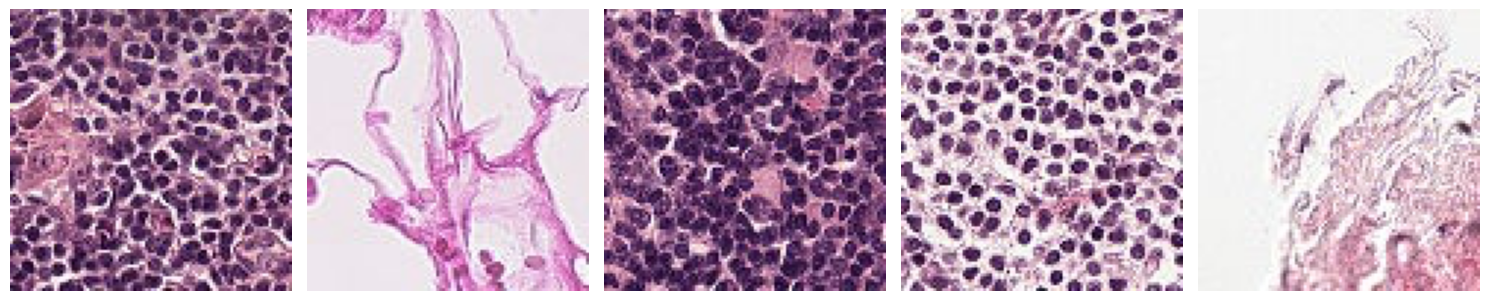

In [59]:
# Some sample images from train dataset
visualize_images_from_directory("./data/train")

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [61]:
df = pd.read_csv('./data/train_labels.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [62]:
df['label'] = df['label'].astype(str)
# need to specify .tif extension
df['id_tif'] = df['id'].apply(lambda x: f"{x}.tif")

In [63]:
df.head()

,id,label,id_tif
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


### Check Class Distribution

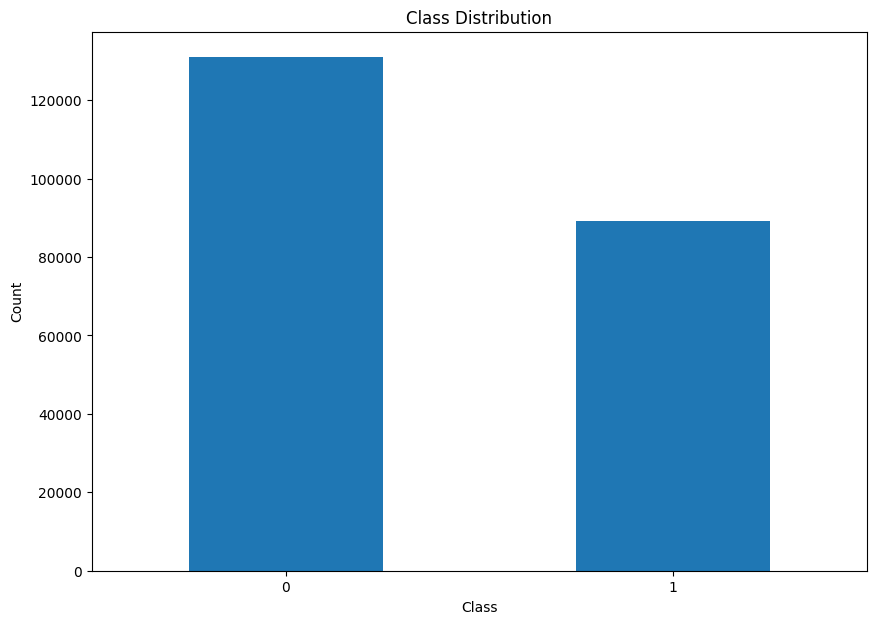

In [64]:
def plot_class_distribution(labels):
    class_counts = labels.value_counts()
    
    plt.figure(figsize=(10, 7))
    class_counts.plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

plot_class_distribution(df['label'])

There is an approximately 4:3 class imbalance. To keep within the scope of this mini project, we will assume that this is acceptable.

In [65]:
submission_df = pd.read_csv('./data/sample_submission.csv')

In [66]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB


In [67]:
submission_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


### Prepare Train/Validation Sets

In [88]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print("Train:", len(train_df))
print("Validation:", len(val_df))

Train: 176020
Validation: 44005


In [89]:
train_dir = './data/train'
test_dir = './data/test'

In [90]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [91]:
# Define generators/augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [92]:
# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='id_tif',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=train_dir,
    x_col='id_tif',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### EDA Conclusion

In this EDA we first briefly inspected pixel intensity of a random image sample. We observed that there was a significant skew towards the right in each color channel. Thus, we will use normalization to address the skewness. Although standardization is preferred for skew, we will revisit the training process with standardization if time permits. Next, we looked at class distribution. Although we found that there was a 4:3 binary class imbalance, we will conclude that this is acceptable. Finally, we prepared a 80-20 train-validation split from the train dataset. With this we are ready to model and train our CNN models to detect metastatic cancer.

## Model Building

In [93]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import plot_model

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


### Simple CNN

In [131]:
input_shape = (96, 96, 3)
num_classes = 1

simple_model = Sequential([
    Input(shape=input_shape),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(32, (7, 7), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (7, 7), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='sigmoid')
])

In [132]:
simple_model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_55 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 17, 17, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 2, 2, 32)       │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,489 (404.25 KB)

 Trainable params: 103,489 (404.25 KB)

 Non-trainable params: 0 (0.00 B)

In [133]:
simple_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [134]:
# fit simple model
history = simple_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10, 
    # steps_per_epoch=len(train_generator),
    # validation_steps=len(val_generator)
)

Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 577s 104ms/step - accuracy: 0.7691 - loss: 0.4851 - val_accuracy: 0.8193 - val_loss: 0.4090
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 584s 106ms/step - accuracy: 0.8144 - loss: 0.4143 - val_accuracy: 0.8327 - val_loss: 0.3830
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 584s 106ms/step - accuracy: 0.8234 - loss: 0.3938 - val_accuracy: 0.8082 - val_loss: 0.4120
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 605s 110ms/step - accuracy: 0.8306 - loss: 0.3809 - val_accuracy: 0.8449 - val_loss: 0.3618
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 592s 107ms/step - accuracy: 0.8402 - loss: 0.3654 - val_accuracy: 0.8447 - val_loss: 0.3595
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 562s 102ms/step - accuracy: 0.8452 - loss: 0.3563 - val_accuracy: 0.8528 - val_loss: 0.3332
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 579s 105ms/step - accuracy: 0.8496 - loss: 0.3445 - val_accuracy: 0.8486 - val_loss: 0.3539
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 555s 101ms/step - ac

### More Layers AND More Learnable Params

In [142]:
complex_model = Sequential([
    Input(shape=input_shape),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='sigmoid')
])

complex_model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_91 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 92, 92, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 44, 44, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 42, 42, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 21, 21, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 19, 19, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 17, 17, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 6, 6, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_88 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,011,329 (7.67 MB)

 Trainable params: 2,011,329 (7.67 MB)

 Non-trainable params: 0 (0.00 B)

In [144]:
complex_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [145]:
# fit complex model
history_complex = complex_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10, 
)

Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 581s 104ms/step - accuracy: 0.7333 - loss: 0.5217 - val_accuracy: 0.7927 - val_loss: 0.4334
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 564s 102ms/step - accuracy: 0.8502 - loss: 0.3480 - val_accuracy: 0.8760 - val_loss: 0.2927
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 559s 101ms/step - accuracy: 0.8732 - loss: 0.3027 - val_accuracy: 0.8898 - val_loss: 0.2693
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 559s 102ms/step - accuracy: 0.8902 - loss: 0.2684 - val_accuracy: 0.9044 - val_loss: 0.2386
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 559s 102ms/step - accuracy: 0.9020 - loss: 0.2469 - val_accuracy: 0.9103 - val_loss: 0.2284
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 561s 102ms/step - accuracy: 0.9016 - loss: 0.2466 - val_accuracy: 0.9079 - val_loss: 0.2324
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 555s 101ms/step - accuracy: 0.9111 - loss: 0.2283 - val_accuracy: 0.9060 - val_loss: 0.2441
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 553s 100ms/step - ac

### Hyperparameter Tuning on Complex Model

- Lower learning rate
- Higher epoch

In [205]:
complex_model_tuned = Sequential([
    Input(shape=input_shape),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='sigmoid')
])

complex_model_tuned.summary()

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_224 (Conv2D)             │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_225 (Conv2D)             │ (None, 92, 92, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_161               │ (None, 46, 46, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_226 (Conv2D)             │ (None, 44, 44, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_227 (Conv2D)             │ (None, 42, 42, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_162               │ (None, 21, 21, 256)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_228 (Conv2D)             │ (None, 19, 19, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_229 (Conv2D)             │ (None, 17, 17, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_163               │ (None, 8, 8, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_230 (Conv2D)             │ (None, 6, 6, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_164               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_47 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,011,329 (7.67 MB)

 Trainable params: 2,011,329 (7.67 MB)

 Non-trainable params: 0 (0.00 B)

In [207]:
from tensorflow.keras.optimizers import Adam

adam_optimizer = Adam(learning_rate=0.0005)

complex_model_tuned.compile(
    optimizer=adam_optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [208]:
# fit complex model with lower learning rate for greater number of epochs
history_complex_tuned = complex_model_tuned.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20, 
)

Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 558s 101ms/step - accuracy: 0.7312 - loss: 0.5165 - val_accuracy: 0.8604 - val_loss: 0.3171
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 551s 100ms/step - accuracy: 0.8738 - loss: 0.3007 - val_accuracy: 0.9095 - val_loss: 0.2313
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 562s 102ms/step - accuracy: 0.9003 - loss: 0.2492 - val_accuracy: 0.8904 - val_loss: 0.2635
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 567s 103ms/step - accuracy: 0.9124 - loss: 0.2234 - val_accuracy: 0.9267 - val_loss: 0.1951
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 552s 100ms/step - accuracy: 0.9219 - loss: 0.2037 - val_accuracy: 0.9273 - val_loss: 0.1899
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 565s 103ms/step - accuracy: 0.9266 - loss: 0.1922 - val_accuracy: 0.9291 - val_loss: 0.1942
Epoch 7/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 557s 101ms/step - accuracy: 0.9304 - loss: 0.1842 - val_accuracy: 0.9293 - val_loss: 0.1825
Epoch 8/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 560s 102ms/step - ac

### Predict and Save

In [212]:
submission_df['id_tif'] = submission_df['id'].apply(lambda x: f"{x}.tif")

In [213]:
submission_df.head()

,id,label,id_tif
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737,0,95596b92e5066c5c52466c90b69ff089b39f2737.tif
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif
3,2c35657e312966e9294eac6841726ff3a748febf,0,2c35657e312966e9294eac6841726ff3a748febf.tif
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif


In [215]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  

test_generator = test_datagen.flow_from_dataframe(
    dataframe=submission_df,
    directory=test_dir,
    x_col='id_tif',
    y_col=None,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 57458 validated image filenames.


In [218]:
submission = submission_df.copy().drop(columns=['id_tif'])

In [220]:
prediction = complex_model_tuned.predict(test_generator)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 468s 260ms/step


In [221]:
prediction

array([[8.6946314e-04],
       [5.0651276e-01],
       [4.3899599e-03],
       ...,
       [2.0174534e-04],
       [1.0725571e-03],
       [7.6663429e-03]], dtype=float32)

In [224]:
submission['label'] = (prediction > 0.5).astype(int)

In [229]:
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [226]:
submission.to_csv('submission_complex_model_tuned.csv', index=False)

### Predict and Save Using Previous Models

In [227]:
submission = submission_df.copy().drop(columns=['id_tif'])
prediction = simple_model.predict(test_generator)
submission['label'] = (prediction > 0.5).astype(int)
submission.to_csv('submission_simple_model.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 150s 83ms/step


In [228]:
submission = submission_df.copy().drop(columns=['id_tif'])
prediction = complex_model.predict(test_generator)
submission['label'] = (prediction > 0.5).astype(int)
submission.to_csv('submission_complex_model.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 149s 83ms/step


### Validation ROC Curves

In [339]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc

In [347]:
def plot_roc(y_true, y_pred, name):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Chance')
    plt.title(name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

In [328]:
val_generator_no_shuffle = val_datagen.flow_from_dataframe(
    val_df,
    directory=train_dir,
    x_col='id_tif',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 44005 validated image filenames belonging to 2 classes.


In [341]:
val_prediction_simple = simple_model.predict(val_generator_no_shuffle)

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 115s 84ms/step


In [342]:
val_prediction_complex = complex_model.predict(val_generator_no_shuffle)

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 116s 84ms/step


In [343]:
val_prediction_complex_tuned = complex_model_tuned.predict(val_generator_no_shuffle)

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 116s 84ms/step


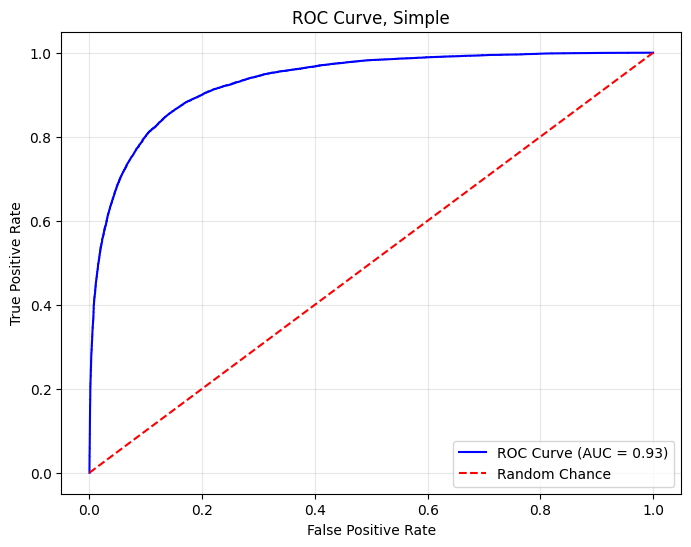

In [348]:
plot_roc(val_df['label'].astype(int), val_prediction_simple, 'ROC Curve, Simple')

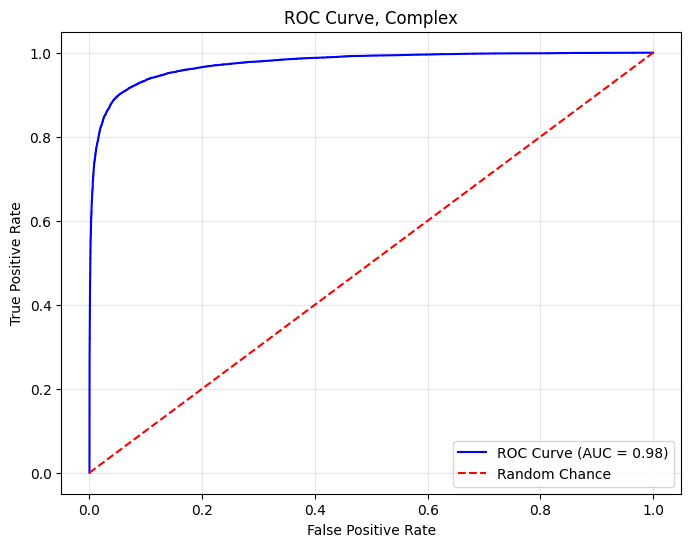

In [349]:
plot_roc(val_df['label'].astype(int), val_prediction_complex, 'ROC Curve, Complex')

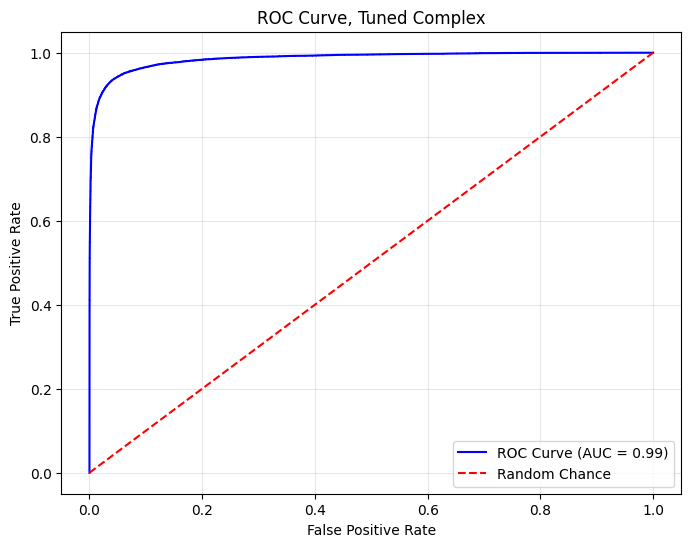

In [350]:
plot_roc(val_df['label'].astype(int), val_prediction_complex_tuned, 'ROC Curve, Tuned Complex')

### Optimize for recall

In [283]:
# try different threshold
submission = submission_df.copy().drop(columns=['id_tif'])
prediction = simple_model.predict(test_generator)
submission['label'] = (prediction > 0.25).astype(int)
submission.to_csv('./submissions_threshold/submission_simple_threshold.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 430s 239ms/step


In [284]:
submission = submission_df.copy().drop(columns=['id_tif'])
prediction1 = complex_model.predict(test_generator)
submission['label'] = (prediction1 > 0.25).astype(int)
submission.to_csv('./submissions_threshold/submission_complex_threshold.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 140s 78ms/step


In [285]:
submission = submission_df.copy().drop(columns=['id_tif'])
prediction2 = complex_model_tuned.predict(test_generator)
submission['label'] = (prediction2 > 0.25).astype(int)
submission.to_csv('./submissions_threshold/submission_tuned_complex_threshold.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 155s 87ms/step


### Accuracy Plots

In [275]:
def plot_accuracy(hist, name):
    hist_train = hist.history['accuracy']
    hist_val = hist.history['val_accuracy']

    plt.figure(figsize=(11, 7))

    plt.plot(range(len(hist_train)), hist_train, marker='o', label = 'accuracy, training')
    plt.plot(range(len(hist_train)), hist_val, marker='o', label = 'accuracy, validation')
    
    plt.xticks(range(len(hist_train)), range(len(hist_train)), rotation=45)
    
    plt.legend() 
    
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(name)
    plt.grid(True)
    plt.show()

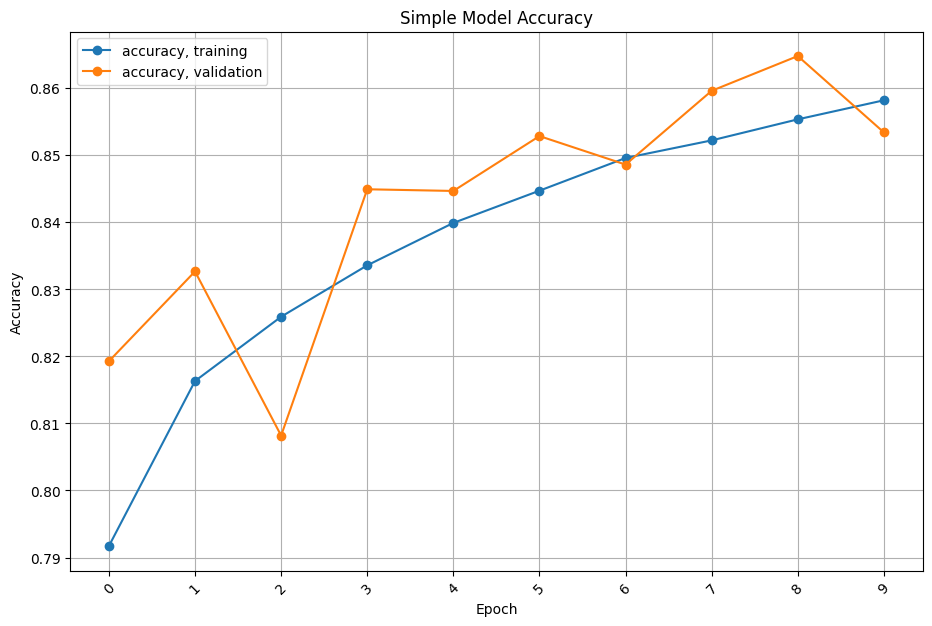

In [276]:
# accuracy plot: simple model
plot_accuracy(history, "Simple Model Accuracy")

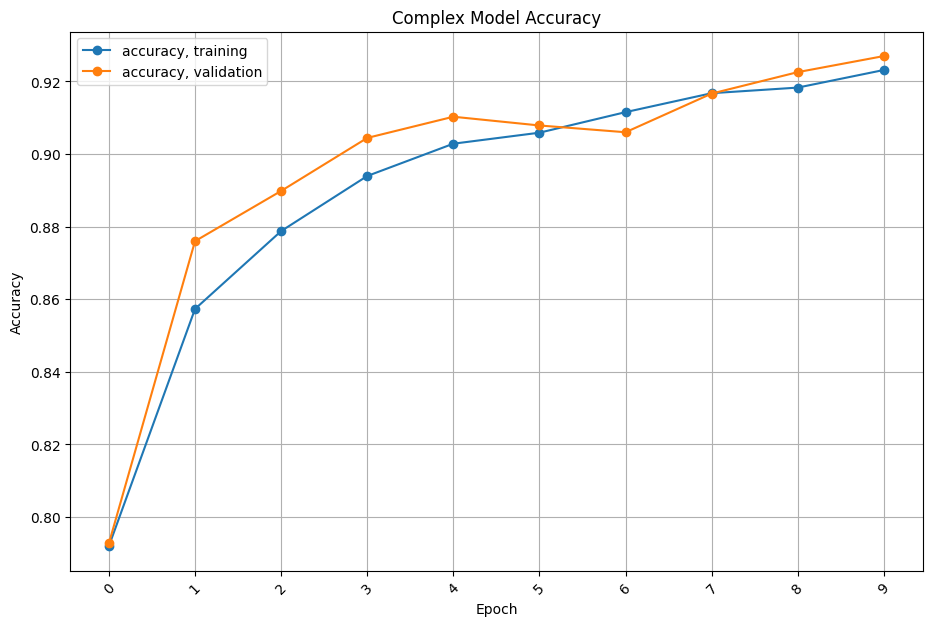

In [277]:
# accuracy plot: complex model
plot_accuracy(history_complex, "Complex Model Accuracy")

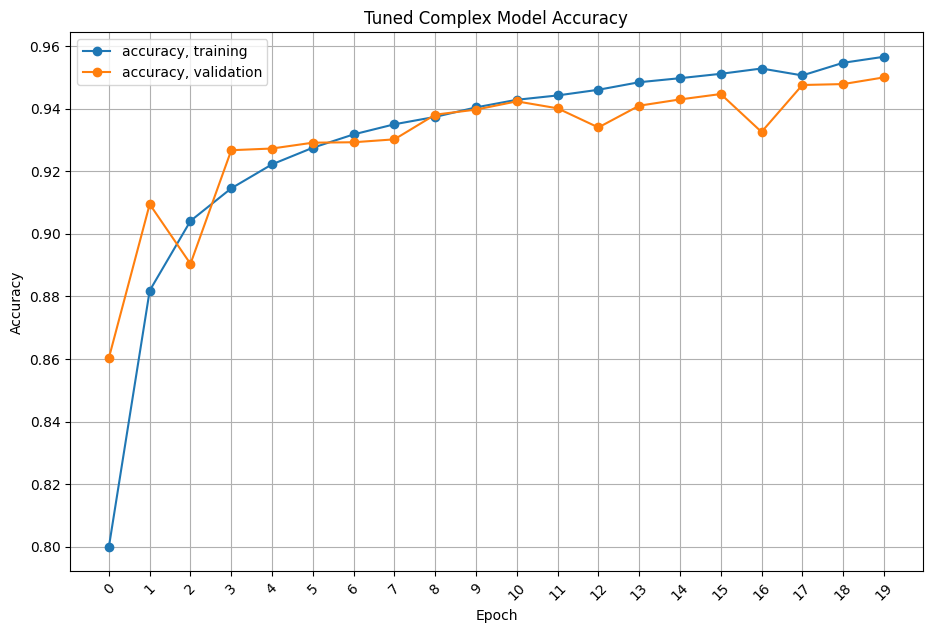

In [278]:
# accuracy plot: tuned complex model
plot_accuracy(history_complex_tuned, "Tuned Complex Model Accuracy")